In [54]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [56]:
#not used currently
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [57]:
#not used currently
def get_best_score_dict(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    score_dict = {}
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
            print(condition)
            if not condition in score_dict:
                score_dict[condition] = {}
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data'].values
            #print(result, '\n\n')
            max_score, error = get_max_score(result)
            score_dict[condition]['score'] = max_score
            score_dict[condition]['error'] = error
    return score_dict

In [58]:
def get_last_scores_df(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    last_scores = []
    errors = []
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
            if "-" in condition:
                condition = condition.split("-")[1]
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data'].values
            #print(result, '\n\n')
            last_score, error = last_score, error = result[-1][0], result[-1][1]
            conditions.append(condition)
            last_scores.append(last_score)
            errors.append(error)
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': last_scores,
    'error': errors, 'condition':conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])
    scores_df = df.sort_values(by='condition')
    return scores_df

In [59]:
scores_df = get_last_scores_df('distilgpt2')

### Quick sanity check

In [60]:
scores_df

,score,error,condition
2,0.445486,0.141692,original
4,0.433109,0.152545,scrambled1
5,0.481103,0.092081,scrambled3
6,0.509842,0.204048,scrambled5
7,0.422906,0.156049,scrambled7
1,0.525676,0.094445,lowpmi
0,0.624232,0.116947,backward
3,0.356489,0.025445,random


In [61]:
def bar_plot(model_identifier,get_last_scores_df):
    colors = sns.color_palette("rocket")
    x_pos = np.arange(len(get_last_scores_df))
    scores = get_last_scores_df['score']
    errors = get_last_scores_df['error']
    conditions = get_last_scores_df['condition']
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
       alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('ceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=60)
    ax.set_title('{}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)

In [62]:
def main_plot(model_identifier):
    scores_df = get_last_scores_df(model_identifier)
    bar_plot(model_identifier,scores_df)

# Ready to plot!

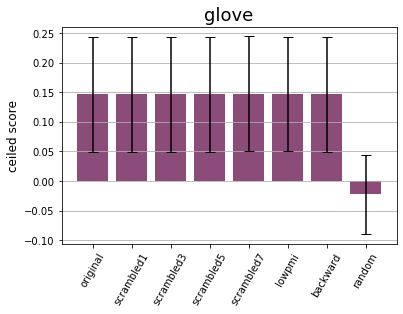

In [63]:
main_plot('glove')

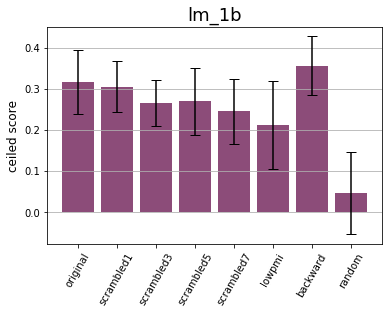

In [64]:
main_plot('lm_1b')

      score     error   condition
2  0.445486  0.141692    original
4  0.433109  0.152545  scrambled1
5  0.481103  0.092081  scrambled3
6  0.509842  0.204048  scrambled5
7  0.422906  0.156049  scrambled7
1  0.525676  0.094445      lowpmi
0  0.624232  0.116947    backward
3  0.356489  0.025445      random


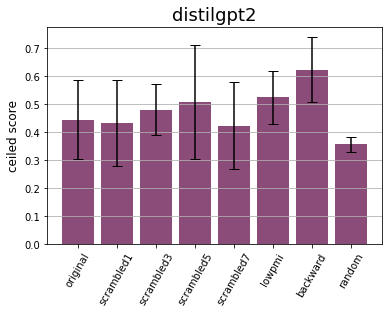

In [65]:
main_plot('distilgpt2')
distilgpt2_scores_df = get_last_scores_df('distilgpt2')
print(distilgpt2_scores_df)

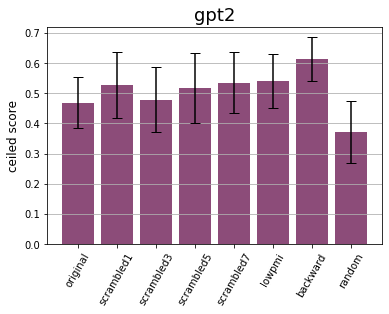

In [66]:
main_plot('gpt2')

# Loop to create subplots

In [67]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(model_list):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    colors = sns.color_palette("rocket")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 7))
    fig2.suptitle('Last-layer score across scrambling conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                scores_df = get_last_scores_df(model_list[counter])
                x_pos = np.arange(len(scores_df))
                scores = scores_df['score']
                errors = scores_df['error']
                conditions = scores_df['condition']

                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                f2_ax[-1].bar(x_pos, scores,
                       yerr=errors,
                       align='center',
                       alpha=0.8, #color intensity
                       ecolor='black',
                       capsize=5, #error bar width
                       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
                f2_ax[-1].set_ylabel('ceiled score',fontsize=12)
                f2_ax[-1].set_xticks(x_pos)
                f2_ax[-1].set_xticklabels(conditions, rotation=60)
                f2_ax[-1].set_title('{}'.format(model_list[counter]),fontsize=18)
                f2_ax[-1].yaxis.grid(True)
                counter += 1

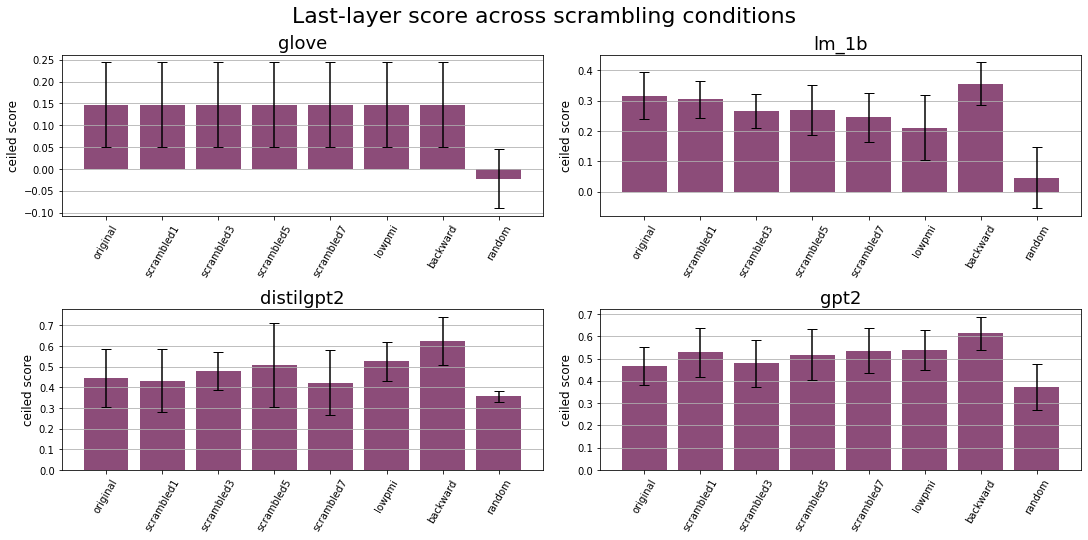

In [83]:
get_subplots_loop(['glove','lm_1b','distilgpt2', 'gpt2'])

_____________________________
_____________________________
# Lineplot over layers

In [69]:
def get_score_dict(model_identifier):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> list of scores across layers,
                                                    error --> list of associated errors}
    """
    score_dict = {}
    for filename in os.listdir(working_dir):
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
            if "-" in condition:
                condition = condition.split("-")[1]
            #print(condition)
            if not condition in score_dict:
                score_dict[condition] = {}
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data'].values
            #print(out['data'].layer) # sanity check which confirms order of layers is correct despite single-digit
            #names in e.g.g, gpt2, (i.e.: drop, encoder.h.0, encoder.h.1, ..., encoder.h.10, encoder.h.11)
            scores = [result[i][0] for i in range(len(result))]
            errors = [result[i][1] for i in range(len(result))]
            score_dict[condition]['score'] = scores
            score_dict[condition]['error'] = errors
    ordered_score_dict = reorder_df(score_dict)
    return ordered_score_dict

In [70]:
def reorder_df(dictionary):
    desired_order_list = ['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random']
    reordered_dict = {k: dictionary[k] for k in desired_order_list}
    return reordered_dict

In [71]:
distilgpt2_score_dict = get_score_dict('distilgpt2')

In [72]:
print(distilgpt2_score_dict.keys())

dict_keys(['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])


In [73]:
print(distilgpt2_score_dict['scrambled7'])

{'score': [0.005539049489326797, 0.14970464170619252, 0.237560435165642, 0.21334449646321693, 0.22330666668304588, 0.3339344479134766, 0.4229061986841613], 'error': [0.04257054092245925, 0.06127134659096494, 0.10616068467862835, 0.09501375209872086, 0.16333758189676043, 0.08780399225569428, 0.156048807773573]}


In [74]:
working_dir2 = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir2)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir2,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            if model_identifier == 'lm_1b':
                layers = [layer.split('/')[1] for layer in layers]
            return layers
            break

In [75]:
get_all_layers('lm_1b')

['lstm_0', 'lstm_1']

In [76]:
def get_layerplot(model_identifier):
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d")
    layers = get_all_layers(model_identifier)
    score_dict = get_score_dict(model_identifier)
    print(score_dict['original'].keys())
        
    fig, ax = plt.subplots()
    
    x = np.array(layers)
    counter = 0
    for key,value in score_dict.items():
        ax.plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
        counter += 1

    conditions = list(distilgpt2_score_dict.keys())

    ax.set_title('Layer neural score evolution across conditions')
    ax.legend(conditions)
    ax.yaxis.set_label_text('ceiled score')
    plt.xticks(rotation= 90)

dict_keys(['score', 'error'])


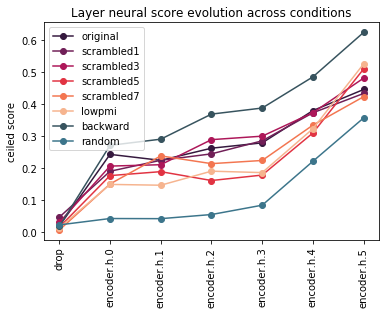

In [77]:
get_layerplot('distilgpt2')

In [78]:
print(get_all_layers('gpt2'))

['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9', 'encoder.h.10', 'encoder.h.11']


dict_keys(['score', 'error'])


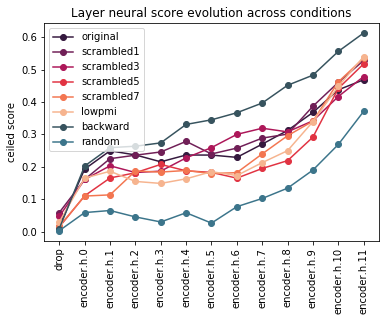

In [79]:
get_layerplot('gpt2')

## Loop models into subplots

In [80]:
import math
from matplotlib.gridspec import GridSpec

def get_lineplots_loop(model_list,error_shading=False):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle('Score evolution of layers over scrambling conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                layers = get_all_layers(model_list[model_counter])
                score_dict = get_score_dict(model_list[model_counter])
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                x = np.array(layers)
                for key,value in score_dict.items():
                    f2_ax[-1].plot(x,np.array(score_dict[key]['score']), '-o',color=line_colors[counter])
                    if error_shading==True:
                        f2_ax[-1].fill_between(x,np.array(score_dict[key]['score'])-np.array(score_dict[key]['error']), np.array(score_dict[key]['score'])+np.array(score_dict[key]['error']),facecolor=line_colors[counter],alpha=0.05)
                    counter += 1

                conditions = list(distilgpt2_score_dict.keys())

                f2_ax[-1].set_title('{}'.format(model_list[model_counter]),fontsize=18)
                f2_ax[-1].yaxis.set_label_text('ceiled score')
                plt.xticks(rotation= 90)
                model_counter += 1
    fig2.legend(conditions, loc='lower right')

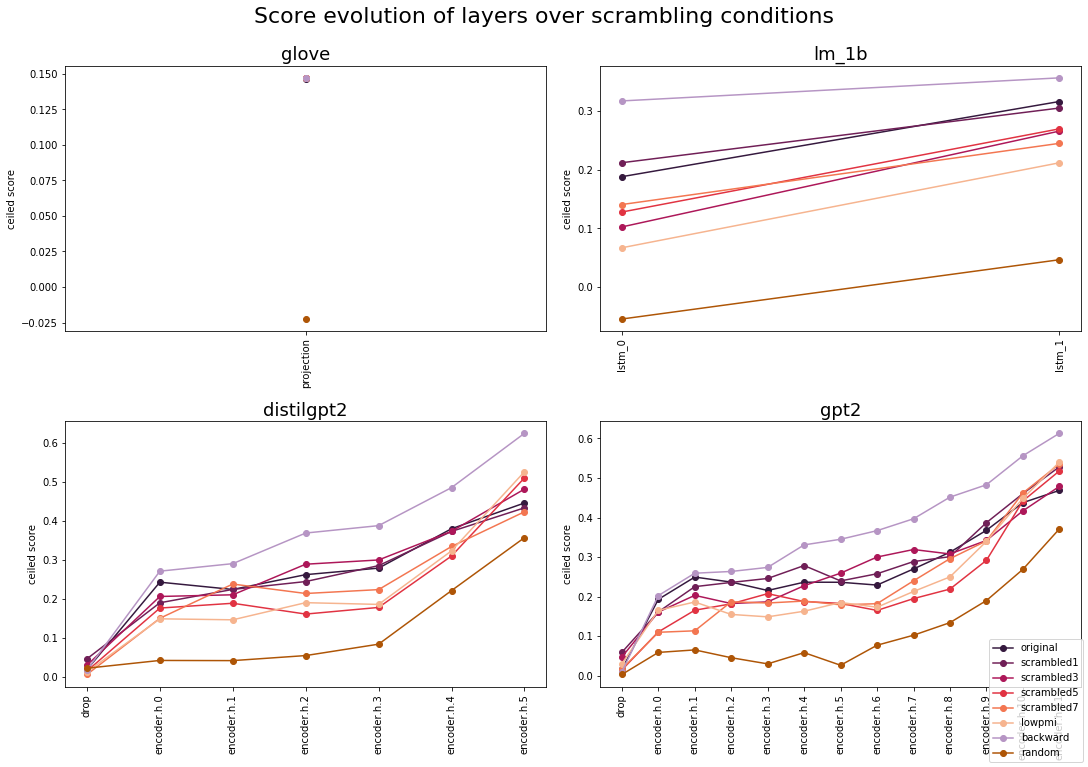

In [81]:
get_lineplots_loop(['glove','lm_1b','distilgpt2','gpt2'])
#with gpt2/alberta >> ValueError: x and y must have same first dimension, but have shapes (1,) and (13,)
#bert-large-uncased-whole-word-masking lowpmi condition missing

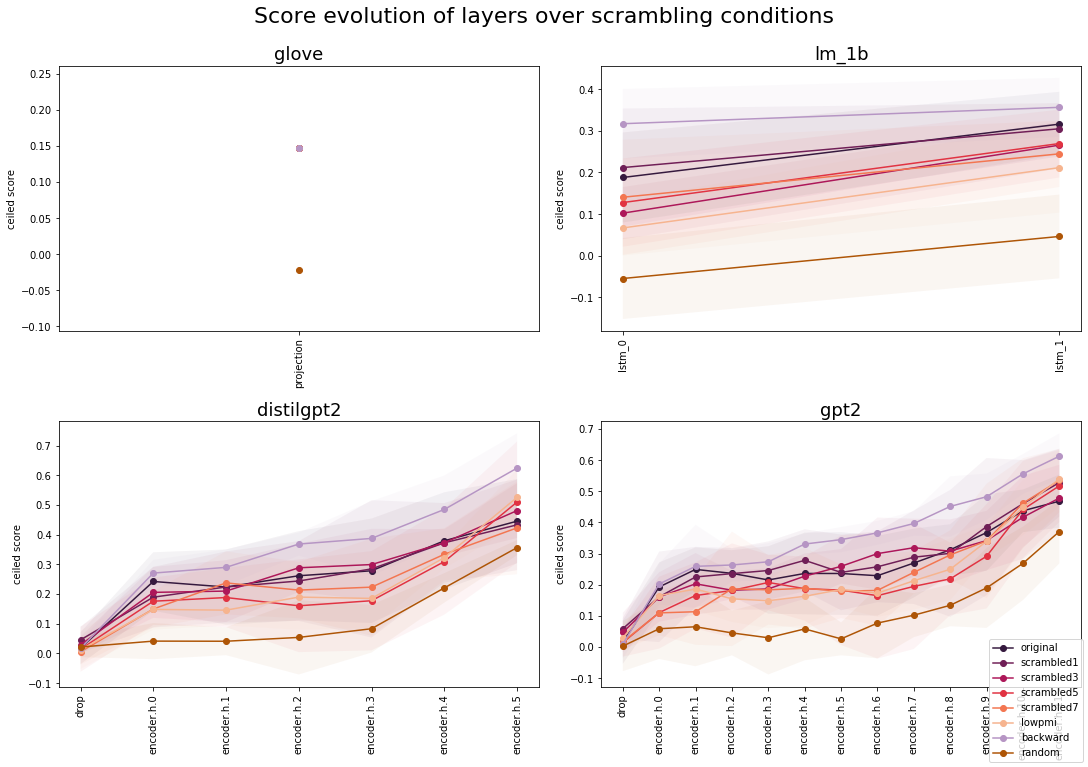

In [82]:
get_lineplots_loop(['glove','lm_1b','distilgpt2','gpt2'],error_shading=True)